Brief Introduction

In this assignment, you will engage in a competition that challenges you to develop an algorithm capable of detecting metastatic cancer in small image patches derived from larger digital pathology scans. The dataset for this task is a modified version of the PatchCamelyon (PCam) benchmark dataset. Unlike the original PCam, which includes duplicate images due to its probabilistic sampling method, the version provided on Kaggle has been curated to exclude these duplicates.

The PCam dataset is particularly intriguing due to its substantial size and the accessibility it offers for those new to this field. As the authors note, it serves as a valuable resource for gaining insights and starting points in the study of medical image analysis.

# Data Visualization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

base_dir = './data/histopathologic-cancer-detection/'
train = './data/histopathologic-cancer-detection/train_labels.csv'
train_img_dir = './data/histopathologic-cancer-detection/train/'
test_img_dir = './data/histopathologic-cancer-detection/test/'

# quick look at the label stats
print("show a preview of the training data.")
full_train_df = pd.read_csv(train)
full_train_df.head()

show a preview of the training data.


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [2]:
# Check the number of images in the train and test datasets
print("Train Size: {}".format(len(os.listdir(train_img_dir))))
print("Test Size: {}".format(len(os.listdir(test_img_dir))))

Train Size: 220025
Test Size: 57458


In [3]:
# Check the number of images in the train and test datasets
numberOfCatagories = full_train_df['label'].unique()
print("Review how many unique catagories are in the label column.")
print(numberOfCatagories)
numberOfCatagories = len(numberOfCatagories)
print("There are " + str(numberOfCatagories) + " unique catagories in the label column.")
print(numberOfCatagories)

Review how many unique catagories are in the label column.
[0 1]
There are 2 unique catagories in the label column.
2


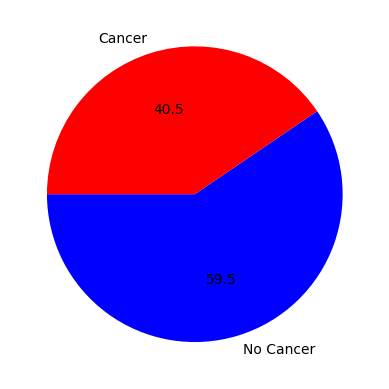

<Figure size 1600x1600 with 0 Axes>

In [4]:
# Plot a pie chart
labels_count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180,
        autopct='%1.1f', colors=['blue','red'])
plt.figure(figsize=(16,16))
plt.show()

In [5]:
labels, counts = np.unique(full_train_df['label'],return_counts=True)
print("Review how many images are in each catagory.")
print(dict(zip(labels, counts)))

Review how many images are in each catagory.
{0: 130908, 1: 89117}


Show counts for each label in a bar chart.


<BarContainer object of 2 artists>

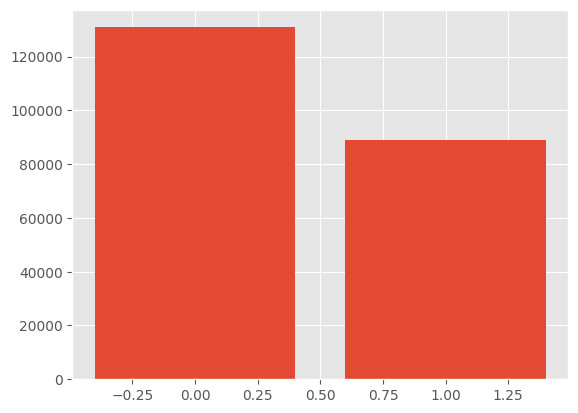

In [6]:
print("Show counts for each label in a bar chart.")
plt.bar(labels, counts)

preview the images in the training set.


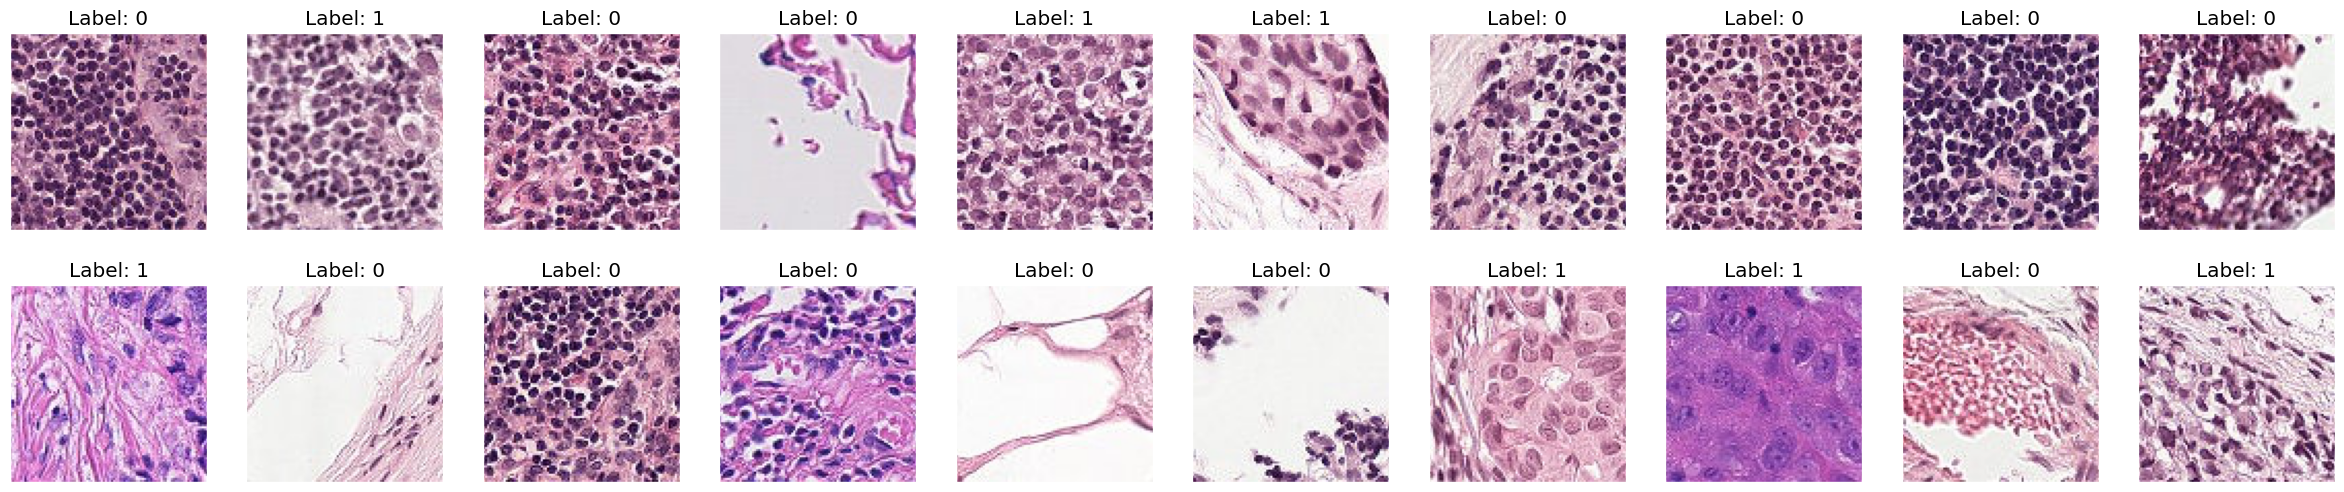

In [7]:
# Preview images
print("preview the images in the training set.")
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [8]:
## Parameters for model

# Hyper parameters
num_epochs = 8
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
# Splitting data into train and val
from sklearn.model_selection import train_test_split
train, val = train_test_split(full_train_df, stratify=full_train_df.label, test_size=0.1)
len(train), len(val)

(198022, 22003)

In [10]:
# Create a custom dataset
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = base_dir, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
# Data augmentation and normalization for training
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = MyDataset(df_data=train, data_dir=train_img_dir, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=train_img_dir, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [12]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [13]:
# Model, loss function and optimizer
model = SimpleCNN().to(device)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [15]:
# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/8], Step [100/1548], Loss: 0.4663
Epoch [1/8], Step [200/1548], Loss: 0.3557
Epoch [1/8], Step [300/1548], Loss: 0.4013
Epoch [1/8], Step [400/1548], Loss: 0.3496
Epoch [1/8], Step [500/1548], Loss: 0.3798
Epoch [1/8], Step [600/1548], Loss: 0.3907
Epoch [1/8], Step [700/1548], Loss: 0.4595
Epoch [1/8], Step [800/1548], Loss: 0.2845
Epoch [1/8], Step [900/1548], Loss: 0.3549
Epoch [1/8], Step [1000/1548], Loss: 0.2075
Epoch [1/8], Step [1100/1548], Loss: 0.3672
Epoch [1/8], Step [1200/1548], Loss: 0.2639
Epoch [1/8], Step [1300/1548], Loss: 0.2790
Epoch [1/8], Step [1400/1548], Loss: 0.3311
Epoch [1/8], Step [1500/1548], Loss: 0.3032
Epoch [2/8], Step [100/1548], Loss: 0.2260
Epoch [2/8], Step [200/1548], Loss: 0.3014
Epoch [2/8], Step [300/1548], Loss: 0.2137
Epoch [2/8], Step [400/1548], Loss: 0.2210
Epoch [2/8], Step [500/1548], Loss: 0.2125
Epoch [2/8], Step [600/1548], Loss: 0.2134
Epoch [2/8], Step [700/1548], Loss: 0.2547
Epoch [2/8], Step [800/1548], Loss: 0.2185
Epoch

In [16]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 22003 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 22003 test images: 95.01431622960506 %


In [18]:
# Create a submission file for the competition using the test data provided
sub = pd.read_csv('./data/histopathologic-cancer-detection/sample_submission.csv')
dataset_valid = MyDataset(df_data=sub, data_dir=test_img_dir, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data, target
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
sub.shape, len(preds)
sub['label'] = preds
print(sub)

                                             id     label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5 -3.333149
1      95596b92e5066c5c52466c90b69ff089b39f2737 -2.032493
2      248e6738860e2ebcf6258cdc1f32f299e0c76914 -3.168109
3      2c35657e312966e9294eac6841726ff3a748febf -2.504579
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6 -3.655271
...                                         ...       ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7 -2.010238
57454  6f3977130212641fd5808210015a609c658dcbff -2.731314
57455  46935f247278539eca74b54d07d666efb528a753 -3.714676
57456  a09bcae08a82120183352e0e869181b2911d3dc1 -2.879515
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b -2.564664

[57458 rows x 2 columns]


In [19]:
sub.to_csv("./submission.csv",index=False)

Result and Conclusion

In this assignment, I have developed a convolutional neural network model to detect metastatic cancer in small image patches derived from larger digital pathology scans. The model can be further improved by tuning the hyperparameters and using a more complex model architecture.